In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# فصل ۳ — تحلیل اکتشافی داده‌ها (EDA)
## درس ۷: EDA برای کیفیت داده (تکراری‌ها، ناسازگاری‌ها، دریفت، مشکلات برچسب)

این درس روی *EDA برای کیفیت داده* تمرکز دارد: چگونه مشکلات کیفیت را به‌صورت سیستماتیک کشف کنیم، اندازه‌گیری کنیم، و بر اساس ریسک اولویت‌بندی کنیم؛ مشکلاتی که می‌توانند بدون هشدار، عملکرد مدل و اعتمادپذیری آن را کاهش دهند.

برای نمایش عملی بررسی‌ها و گردش‌کارهای تشخیصی، از چند دیتاست موجود در مخزن استفاده می‌کنیم:
- `airports.csv` برای یکتایی و اعتبارسنجی اسکیمـا
- `ConsumerComplaints.csv` برای فیلدهای دسته‌ای/متنیِ به‌هم‌ریخته و بررسی سازگاری
- `earthquake.csv` برای تحلیل دریفت مبتنی بر زمان
- `diabetes.csv` برای مشکلات برچسب و روش‌های ابتکاریِ تشخیص نویز برچسب


### چه چیزهایی یاد می‌گیرید

در پایان این نوت‌بوک، قادر خواهید بود:

1. یک *چک‌لیست EDA برای کیفیت داده* بسازید که در پروژه‌های مختلف قابل تکرار باشد.
2. **تکراری‌ها** را (تکرار ردیف، تکرار کلید، و «شبه‌تکراری») شناسایی کنید و اثر آن‌ها را بر مدل بفهمید.
3. **ناسازگاری‌ها** در فرمت‌ها، واحدها، دسته‌بندی‌ها و قیود منطقی را پیدا کنید.
4. **دریفت داده** را با متریک‌های عملی (PSI، واگرایی هیستوگرام) و برش زمانی اندازه‌گیری کنید.
5. **مشکلات برچسب** (برچسب‌های متناقض، نمونه‌های مشکوک، نویز برچسب) را با EDA و مدل‌های ساده بررسی کنید.
6. یک **گزارش کیفیت** قابل اقدام تولید کنید که رفع مشکل‌ها را بر اساس ریسک و هزینه اولویت‌بندی کند.

### چرا مهم است؟

در یادگیری نظارت‌شده، تابع هدف آموزشی فقط یک تقریب از واقعیت است. اگر دیتاست با تکراری‌ها، کدگذاری‌های ناسازگار، دریفت یا خطاهای برچسب آلوده شده باشد، مدل می‌تواند سیگنال‌های کاذب یاد بگیرد یا در متریک‌های آفلاین «خوب» به نظر برسد اما در عمل شکست بخورد.

یک مدل ذهنی مفید:

- **مشکلات کیفیت داده** → توزیع نمونه‌هایی که از آن‌ها یاد می‌گیرید را منحرف می‌کند (و گاهی متریک‌های ارزیابی را نیز)
- **انتخاب‌های مدل‌سازی** → تعیین می‌کند چقدر به این انحراف‌ها حساس هستید
- **پایش** → سیستم هشدار زودهنگام شما برای پسرفت کیفیت در طول زمان است


### نمادگذاری و فرمول‌های کلیدی

در این درس چند متریک سبک استفاده می‌کنیم که با هیستوگرام به‌سادگی قابل محاسبه هستند.

#### شاخص پایداری جمعیت (PSI)

برای دو توزیع (خط‌مبنا و پنجره فعلی) که به $K$ بازه تقسیم شده‌اند، داریم:

$$
\mathrm{PSI} = \sum_{k=1}^{K} (\hat{p}_k - \hat{q}_k)\,\ln\left(\frac{\hat{p}_k}{\hat{q}_k}\right)
$$

که در آن $\hat{p}_k$ سهم خط‌مبنا در بازه $k$ و $\hat{q}_k$ سهم پنجره فعلی است.

تفسیر PSI وابسته به زمینه است؛ PSI عمدتاً یک متریک *غربال‌گری* است: مقدار بزرگ‌تر یعنی احتمال دریفت بیشتر و نیاز به بررسی دقیق‌تر.

#### واگرایی جنسن–شنون (JSD)

برای توزیع‌های گسسته $p$ و $q$، با $m=\frac{1}{2}(p+q)$:

$$
\mathrm{JSD}(p,q) = \frac{1}{2}\mathrm{KL}(p\|m) + \frac{1}{2}\mathrm{KL}(q\|m)
$$

JSD متقارن و کراندار است، بنابراین برای داشبوردها مناسب است.


### نگاه خروجی‌محور

«EDA برای کیفیت داده» را یک خروجی مهندسی بدانید، نه یک نوت‌بوک یک‌بارمصرف. هدف این است که تولید کنید:

- یک **خلاصه کیفیت** (چه چیزهایی مشکل دارد)
- یک **ارزیابی ریسک** (چرا برای تصمیم‌گیری مهم است؟)
- یک **برنامه اصلاح** (چگونه رفع یا کنترل کنیم؟)
- یک **برنامه پایش** (چگونه جلوی برگشت مشکل‌ها را بگیریم؟)

در ادامه، ابزارهای قابل استفاده مجدد پیاده‌سازی می‌کنیم و سپس روی چند دیتاست اجرا می‌کنیم.


In [2]:
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### مسیر دیتاست‌ها (نسبت به محل نوت‌بوک در مخزن)

دیتاست‌ها را با مسیرهای نسبی (مطابق ساختار مخزن) بارگذاری می‌کنیم.

In [3]:
PATHS = {
    "airports": "../../../Datasets/Clustering/airports.csv",
    "complaints": "../../../Datasets/Clustering/ConsumerComplaints.csv",
    "earthquake": "../../../Datasets/Regression/earthquake.csv",
    "diabetes": "../../../Datasets/Classification/diabetes.csv",
}

def read_csv(path: str, **kwargs) -> pd.DataFrame:
    """Read a CSV with a consistent set of defaults and helpful errors."""
    try:
        return pd.read_csv(path, **kwargs)
    except FileNotFoundError as e:
        raise FileNotFoundError(
            f"Could not find: {path}. Make sure the repository datasets are present and the relative path is correct."
        ) from e

def show_head(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    return df.head(n)

def basic_overview(df: pd.DataFrame, name: str = "df") -> None:
    print(f"[{name}] shape = {df.shape}")
    display(df.head(5))
    display(pd.DataFrame({
        "dtype": df.dtypes.astype(str),
        "missing": df.isna().sum(),
        "missing_%": (df.isna().mean() * 100).round(2),
        "n_unique": df.nunique(dropna=True),
    }).sort_values("missing_%", ascending=False))

## ۱) یک ابزارکِ قابل تکرار برای EDA کیفیت داده

یک گردش‌کار خوب با تعداد کمی بررسی قابل استفاده مجدد شروع می‌شود. این بررسی‌ها باید:

- **قطعی و تکرارپذیر** باشند (یک دیتاست → همان یافته‌ها)
- در گذر زمان و بین دیتاست‌ها **قابل مقایسه** باشند
- **قابل اقدام** باشند (هر یافته به یک اصلاح یا تصمیم مشخص منجر شود)

در ادامه برای موارد زیر ابزار می‌سازیم:

- پروفایل پایه (مقادیر گم‌شده، نوع داده، خلاصه آماری)
- تشخیص تکراری‌ها (ردیفی/کلیدی/شبه‌تکراری)
- بررسی سازگاری (رِجِکس، بازه‌ها، قیود منطقی)
- متریک‌های دریفت (PSI، JSD) برای داده‌های عددی و دسته‌ای
- ابتکارهای شناسایی مشکلات برچسب (تکراری‌های متناقض، اختلاف با اطمینان بالا)


In [4]:
@dataclass
class DuplicateSummary:
    n_rows: int
    n_exact_duplicate_rows: int
    exact_duplicate_rate: float
    n_duplicate_keys: Optional[int] = None
    duplicate_key_rate: Optional[float] = None

def exact_duplicates(df: pd.DataFrame) -> DuplicateSummary:
    dup_mask = df.duplicated(keep=False)
    n_dup = int(dup_mask.sum())
    return DuplicateSummary(
        n_rows=df.shape[0],
        n_exact_duplicate_rows=n_dup,
        exact_duplicate_rate=(n_dup / max(df.shape[0], 1)),
    )

def key_duplicates(df: pd.DataFrame, key_cols: List[str]) -> DuplicateSummary:
    base = exact_duplicates(df)
    dup_key = df.duplicated(subset=key_cols, keep=False)
    n_dup_key = int(dup_key.sum())
    base.n_duplicate_keys = n_dup_key
    base.duplicate_key_rate = n_dup_key / max(df.shape[0], 1)
    return base

def near_duplicates_text(series: pd.Series, min_ratio: float = 0.92, max_pairs: int = 30) -> List[Tuple[int, int, float]]:
    # Naive near-duplicate detection for text using SequenceMatcher ratio.
    # Returns pairs (i, j, ratio). This is O(n^2); use for small samples or triage only.
    from difflib import SequenceMatcher
    s = series.fillna("").astype(str).tolist()
    pairs = []
    n = len(s)
    checked = 0
    for i in range(n):
        for j in range(i + 1, n):
            if checked >= max_pairs * 200:
                break
            r = SequenceMatcher(None, s[i], s[j]).ratio()
            checked += 1
            if r >= min_ratio and s[i] and s[j]:
                pairs.append((i, j, r))
                if len(pairs) >= max_pairs:
                    return pairs
    return pairs

def normalize_strings(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    for c in cols:
        if c in out.columns:
            out[c] = out[c].astype(str).str.strip()
            out[c] = out[c].str.replace(r"\s+", " ", regex=True)
    return out

def regex_invalid_mask(series: pd.Series, pattern: str, allow_na: bool = True) -> pd.Series:
    s = series.astype("string")
    ok = s.str.match(pattern, na=allow_na)
    return ~ok

def numeric_range_invalid_mask(series: pd.Series, low: float = -np.inf, high: float = np.inf) -> pd.Series:
    x = pd.to_numeric(series, errors="coerce")
    return (x < low) | (x > high)

def psi_from_hist(p: np.ndarray, q: np.ndarray, eps: float = 1e-8) -> float:
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.clip(p, eps, None)
    q = np.clip(q, eps, None)
    p = p / p.sum()
    q = q / q.sum()
    return float(np.sum((p - q) * np.log(p / q)))

def jsd_from_hist(p: np.ndarray, q: np.ndarray, eps: float = 1e-8) -> float:
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.clip(p, eps, None)
    q = np.clip(q, eps, None)
    p = p / p.sum()
    q = q / q.sum()
    m = 0.5 * (p + q)

    def kl(a, b):
        return float(np.sum(a * np.log(a / b)))

    return 0.5 * kl(p, m) + 0.5 * kl(q, m)

def hist_proportions(x: pd.Series, bins: int = 10, range_: Optional[Tuple[float, float]] = None) -> np.ndarray:
    v = pd.to_numeric(x, errors="coerce").dropna().values
    if v.size == 0:
        return np.ones(bins) / bins
    if range_ is None:
        lo, hi = np.nanpercentile(v, [1, 99])
        if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
            lo, hi = np.nanmin(v), np.nanmax(v)
            if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
                lo, hi = 0.0, 1.0
        range_ = (float(lo), float(hi))
    counts, edges = np.histogram(v, bins=bins, range=range_)
    total = counts.sum()
    if total == 0:
        return np.ones(bins) / bins
    return counts / total

def cat_proportions(x: pd.Series, top_k: int = 20) -> pd.Series:
    s = x.fillna("<<NA>>").astype(str)
    vc = s.value_counts(dropna=False)
    if len(vc) > top_k:
        vc_top = vc.iloc[:top_k]
        other = vc.iloc[top_k:].sum()
        vc_top.loc["<<OTHER>>"] = other
        vc = vc_top
    return vc / vc.sum()

def align_categories(p: pd.Series, q: pd.Series) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    cats = sorted(set(p.index).union(set(q.index)))
    p_aligned = np.array([p.get(c, 0.0) for c in cats], dtype=float)
    q_aligned = np.array([q.get(c, 0.0) for c in cats], dtype=float)
    return p_aligned, q_aligned, cats

def drift_report_numeric(df: pd.DataFrame, col: str, mask_a: pd.Series, mask_b: pd.Series, bins: int = 10) -> Dict[str, float]:
    a = df.loc[mask_a, col]
    b = df.loc[mask_b, col]
    combined = pd.to_numeric(pd.concat([a, b]), errors="coerce").dropna()
    if combined.empty:
        return {"psi": np.nan, "jsd": np.nan}
    lo, hi = np.nanpercentile(combined, [1, 99])
    if lo == hi:
        lo, hi = float(combined.min()), float(combined.max())
        if lo == hi:
            lo, hi = lo - 0.5, hi + 0.5
    p = hist_proportions(a, bins=bins, range_=(lo, hi))
    q = hist_proportions(b, bins=bins, range_=(lo, hi))
    return {"psi": psi_from_hist(p, q), "jsd": jsd_from_hist(p, q)}

def drift_report_categorical(df: pd.DataFrame, col: str, mask_a: pd.Series, mask_b: pd.Series, top_k: int = 20) -> Dict[str, float]:
    p = cat_proportions(df.loc[mask_a, col], top_k=top_k)
    q = cat_proportions(df.loc[mask_b, col], top_k=top_k)
    p_aligned, q_aligned, _ = align_categories(p, q)
    return {"psi": psi_from_hist(p_aligned, q_aligned), "jsd": jsd_from_hist(p_aligned, q_aligned)}

def plot_hist_compare(df: pd.DataFrame, col: str, mask_a: pd.Series, mask_b: pd.Series, bins: int = 30, title: str = "") -> None:
    a = pd.to_numeric(df.loc[mask_a, col], errors="coerce").dropna().values
    b = pd.to_numeric(df.loc[mask_b, col], errors="coerce").dropna().values
    plt.figure(figsize=(9, 4))
    plt.hist(a, bins=bins, alpha=0.6, label="A")
    plt.hist(b, bins=bins, alpha=0.6, label="B")
    plt.title(title or f"{col}: distribution comparison")
    plt.legend()
    plt.show()

def plot_top_categories(df: pd.DataFrame, col: str, mask: pd.Series, top_k: int = 15, title: str = "") -> None:
    props = cat_proportions(df.loc[mask, col], top_k=top_k).sort_values(ascending=False)
    plt.figure(figsize=(10, 4))
    props.plot(kind="bar")
    plt.title(title or f"{col}: top categories")
    plt.ylabel("proportion")
    plt.show()

## ۲) چک‌لیست کیفیت داده برای EDA

یک چک‌لیست عملی را می‌توان در پنج دسته قرار داد:

1. **کامل‌بودن**: الگوهای گمشدگی و اینکه آیا گمشدگی «اطلاعاتی» است یا نه.
2. **یکتایی**: تکراری‌ها، برخورد کلیدها، و تکرار موجودیت‌ها.
3. **اعتبار**: نوع داده، بازه‌ها، قوانین اسکیمـا، فرمت‌های رِجِکس، محدودیت‌های دامنه.
4. **سازگاری**: سازگاری دسته‌ها، واحدها، منطقه‌های زمانی، نام‌گذاری و منطق بین‌ستونی.
5. **به‌موقع بودن / دریفت**: آیا دیتاست در گذر زمان پایدار است؟ نسبت به خط‌مبنا تغییر دارد؟

در ادامه، هر بخش را با مثال‌های واقعی پیاده‌سازی می‌کنیم.


## ۳) تکراری‌ها و یکتایی (با `airports.csv`)

تکراری بودن همیشه «غلط» نیست؛ گاهی نشان‌دهنده رویدادهای تکرارشونده است. مشکل زمانی است که تکراری‌ها:

- اندازه نمونه مؤثر را باد می‌کنند (مدل بیش‌ازحد مطمئن می‌شود)
- باعث نشت اطلاعات بین آموزش/آزمون می‌شوند (یک موجودیت در هر دو سمت دیده می‌شود)
- سیگنال‌های آموزشی متناقض ایجاد می‌کنند (شبه‌تکراری با برچسب متفاوت)

از **تکراری‌های دقیق** و **تکراری‌های کلیدی** شروع می‌کنیم و سپس شبه‌تکراری‌ها را بررسی می‌کنیم.


In [5]:
# Load airports
airports = read_csv(PATHS["airports"])

basic_overview(airports, "airports")

# Exact duplicates (entire row duplicated)
dup_summary = exact_duplicates(airports)
dup_summary

[airports] shape = (83125, 19)


,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,icao_code,iata_code,gps_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total RF Heliport,40.070985,-74.933689,11.0,NaN,US,US-PA,Bensalem,no,NaN,NaN,K00A,00A,https://www.penndot.pa.gov/TravelInPA/airports...,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,NaN,NaN,00AA,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,NaN,NaN,00AK,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,NaN,NaN,00AL,00AL,NaN,NaN,NaN
4,506791,00AN,small_airport,Katmai Lodge Airport,59.093287,-156.456699,80.0,NaN,US,US-AK,King Salmon,no,NaN,NaN,00AN,00AN,NaN,NaN,NaN


,dtype,missing,missing_%,n_unique
home_link,object,78820,94.82,4256
icao_code,object,74488,89.61,8637
iata_code,object,74046,89.08,9079
wikipedia_link,object,66610,80.13,16403
keywords,object,62888,75.65,19746
local_code,object,47458,57.09,34157
gps_code,object,39837,47.92,43288
continent,object,39162,47.11,6
elevation_ft,float64,14484,17.42,6411
municipality,object,4688,5.64,37144


DuplicateSummary(n_rows=83125, n_exact_duplicate_rows=0, exact_duplicate_rate=0.0, n_duplicate_keys=None, duplicate_key_rate=None)

In [6]:
# Key duplicates: which columns behave like identifiers?
# We'll inspect a few likely keys.
key_candidates = ["id", "ident", "gps_code", "local_code", "iata_code", "icao_code", "name"]

# Keep only columns that actually exist
key_candidates = [c for c in key_candidates if c in airports.columns]
key_candidates

['id', 'ident', 'gps_code', 'local_code', 'iata_code', 'icao_code', 'name']

In [7]:
# Check duplicates for individual key columns
rows = []
for c in key_candidates:
    summ = key_duplicates(airports, [c])
    rows.append({
        "key": c,
        "n_rows": summ.n_rows,
        "n_duplicate_keys_rows": summ.n_duplicate_keys,
        "duplicate_key_rate": summ.duplicate_key_rate,
        "n_unique": airports[c].nunique(dropna=True),
        "na_rate": airports[c].isna().mean(),
    })

dup_by_key = pd.DataFrame(rows).sort_values("duplicate_key_rate", ascending=False)
dup_by_key

,key,n_rows,n_duplicate_keys_rows,duplicate_key_rate,n_unique,na_rate
5,icao_code,83125,74488,0.896096,8637,0.896096
4,iata_code,83125,74046,0.890779,9079,0.890779
3,local_code,83125,50249,0.604499,34157,0.570923
2,gps_code,83125,39837,0.479242,43288,0.479242
6,name,83125,7063,0.084968,78640,0.000000
1,ident,83125,0,0.000000,83125,0.000000
0,id,83125,0,0.000000,83125,0.000000


In [8]:
# Investigate the most problematic key (highest duplicate_key_rate)
worst = dup_by_key.iloc[0]["key"]
print("Worst key by duplicate rate:", worst)

mask = airports.duplicated(subset=[worst], keep=False) & airports[worst].notna()
sus = airports.loc[mask, [worst, "type", "name", "latitude_deg", "longitude_deg", "iso_country", "iso_region", "municipality"]].sort_values(worst).head(30)
sus

Worst key by duplicate rate: icao_code


,icao_code,type,name,latitude_deg,longitude_deg,iso_country,iso_region,municipality


### اعتبارسنجی: بازه‌های عرض/طول جغرافیایی و سلامت اسکیمـا

برای داده‌های مکانی، قوانین ساده خیلی سریع تعداد زیادی مشکل را آشکار می‌کند:

- عرض جغرافیایی در $[-90, 90]$
- طول جغرافیایی در $[-180, 180]$
- ارتفاع باید منطقی باشد (برای اکثر فرودگاه‌ها منفی نیست، اما در برخی نقاط نزدیک/پایین سطح دریا ممکن است منفی باشد)

در ادامه ماسک‌های نامعتبر را محاسبه می‌کنیم و نمونه‌ها را می‌بینیم.


In [9]:
lat_invalid = numeric_range_invalid_mask(airports["latitude_deg"], -90, 90)
lon_invalid = numeric_range_invalid_mask(airports["longitude_deg"], -180, 180)

print("Invalid latitude rows:", int(lat_invalid.sum()))
print("Invalid longitude rows:", int(lon_invalid.sum()))

display(airports.loc[lat_invalid | lon_invalid, ["ident", "name", "latitude_deg", "longitude_deg"]].head(10))

Invalid latitude rows: 0
Invalid longitude rows: 0


,ident,name,latitude_deg,longitude_deg


### تکرار موجودیت: آیا «تکرار کلید» همیشه بد است؟

فرض کنید `ident` تکرار شود. این می‌تواند به دلایل زیر باشد:

- چند رکورد برای یک تأسیسات در زمان‌های مختلف
- ادغام داده از چند منبع
- برخورد بین کدهای محلی و کدهای جهانی
- نبود نرمال‌سازی (یک موجودیت با املای متفاوت)

در گزارش کیفیت، نباید صرفاً تکراری‌ها را حذف کرد. بهتر است:
1. مشخص کنید «موجودیت» چیست (فرودگاه؟ باند؟ هلی‌پورت؟ نسخه رکورد؟)
2. یک **کلید اصلی** و مجموعه **ویژگی‌های پایدار** تعیین کنید
3. تصمیم بگیرید *ادغام/حذف تکراری/یا نگه‌داشت به عنوان رویداد*

در ادامه یک ابتکار ساده نشان می‌دهیم: اگر تکراری‌ها مکان و نام مشابه داشته باشند، احتمالاً زائد هستند.


In [10]:
# Heuristic redundancy check: for duplicated ident, compare name/location similarity
if "ident" in airports.columns:
    dmask = airports.duplicated(subset=["ident"], keep=False) & airports["ident"].notna()
    d = airports.loc[dmask, ["ident", "name", "latitude_deg", "longitude_deg", "type"]].copy()
    # round coordinates for coarse grouping
    d["lat_r"] = pd.to_numeric(d["latitude_deg"], errors="coerce").round(3)
    d["lon_r"] = pd.to_numeric(d["longitude_deg"], errors="coerce").round(3)
    grp = d.groupby(["ident", "lat_r", "lon_r"])["name"].nunique().reset_index(name="n_unique_names")
    display(grp.sort_values("n_unique_names", ascending=False).head(15))
else:
    print("Column 'ident' not found.")

,ident,lat_r,lon_r,n_unique_names


### شبه‌تکراری‌ها (غربال‌گری با شباهت متنی)

شبه‌تکراری‌ها در دیتاست‌های متنی رایج‌اند و می‌توانند باعث شوند:

- یک رخداد چندبار شمرده شود
- برای متن تقریباً یکسان، برچسب‌های متفاوت داشته باشید
- موجودیت‌های «تقریباً یکسان» که باید یکپارچه شوند

در ادامه یک زیرنمونه کوچک از روایت شکایت‌ها (در صورت وجود) برمی‌داریم و با یک نسبت شباهت ساده شبه‌تکراری‌ها را پیدا می‌کنیم. این ابزار برای تولید نیست؛ یک ابزار *غربال‌گری* برای یافتن زوج‌های مشکوک است.


In [11]:
# Load complaints dataset
complaints = read_csv(PATHS["complaints"])

basic_overview(complaints, "complaints")

C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27944\679595678.py:11: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path, **kwargs)


[complaints] shape = (65499, 18)


,Date Received,Product Name,Sub Product,Issue,Sub Issue,Consumer Complaint Narrative,Company Public Response,Company,State Name,Zip Code,Tags,Consumer Consent Provided,Submitted via,Date Sent to Company,Company Response to Consumer,Timely Response,Consumer Disputed,Complaint ID
0,2013-07-29,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,NaN,NaN,Wells Fargo & Company,VA,24540,NaN,NaN,Phone,2013-07-30,Closed with explanation,Yes,No,468882
1,2013-07-29,Bank account or service,Checking account,Using a debit or ATM card,NaN,NaN,NaN,Wells Fargo & Company,CA,95992,Older American,NaN,Web,2013-07-31,Closed with explanation,Yes,No,468889
2,2013-07-29,Bank account or service,Checking account,"Account opening, closing, or management",NaN,NaN,NaN,Santander Bank US,NY,10065,NaN,NaN,Fax,2013-07-31,Closed,Yes,No,468879
3,2013-07-29,Bank account or service,Checking account,Deposits and withdrawals,NaN,NaN,NaN,Wells Fargo & Company,GA,30084,NaN,NaN,Web,2013-07-30,Closed with explanation,Yes,No,468949
4,2013-07-29,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Franklin Credit Management,CT,6106,NaN,NaN,Web,2013-07-30,Closed with explanation,Yes,No,475823


,dtype,missing,missing_%,n_unique
Company Public Response,object,63049,96.26,9
Consumer Complaint Narrative,object,62885,96.01,2592
Consumer Consent Provided,object,60739,92.73,3
Tags,object,55818,85.22,3
Sub Issue,object,34841,53.19,67
Sub Product,object,18564,28.34,45
Consumer Disputed,object,1108,1.69,2
Zip Code,object,478,0.73,14851
State Name,object,478,0.73,59
Date Received,object,0,0.00,683


In [12]:
text_col = "Consumer Complaint Narrative"
if text_col in complaints.columns:
    # Take a small sample where narrative exists
    sample = complaints[text_col].dropna().astype(str)
    sample = sample[sample.str.len() >= 60].sample(n=min(250, len(sample)), random_state=RANDOM_STATE)
    pairs = near_duplicates_text(sample.reset_index(drop=True), min_ratio=0.92, max_pairs=15)
    print("Near-duplicate pairs found:", len(pairs))
    for i, j, r in pairs[:10]:
        print("="*80)
        print(f"pair (i={i}, j={j}), ratio={r:.3f}")
        print("A:", sample.iloc[i][:280].replace("\n", " "))
        print("B:", sample.iloc[j][:280].replace("\n", " "))
else:
    print(f"Column '{text_col}' not found in complaints.")

Near-duplicate pairs found: 0


## ۴) ناسازگاری‌ها و نقض قیود (با `ConsumerComplaints.csv`)

ناسازگاری زمانی رخ می‌دهد که داده یک قاعده یا انتظار را نقض کند. این مشکل‌ها اغلب از گمشدگی هم خطرناک‌ترند چون بی‌سروصدا ویژگی‌های غلط تولید می‌کنند.

دسته‌های رایج ناسازگاری:

- **ناسازگاری فرمت**: تاریخ‌ها، شناسه‌ها، کدپستی، حروف بزرگ/کوچک، فاصله‌ها، جداکننده‌ها
- **ناسازگاری دسته‌ها**: “NY”، “New York”، “new york”، فاصله انتهایی، غلط تایپی
- **ناسازگاری منطقی**: تاریخ پایان قبل از شروع؛ سن منفی؛ قیمت خالی اما نوع اتاق نشان‌دهنده پرداختی بودن
- **ناسازگاری واحد**: متر در برابر فوت؛ دلار در برابر سنت؛ فارنهایت در برابر سلسیوس

در ادامه با قوانین ساده بررسی می‌کنیم و اندازه مسئله را کمی‌سازی می‌کنیم.


In [13]:
# Parse dates and check order consistency when both exist
date_received = "Date Received"
date_sent = "Date Sent to Company"

for c in [date_received, date_sent]:
    if c in complaints.columns:
        complaints[c] = pd.to_datetime(complaints[c], errors="coerce")

if date_received in complaints.columns and date_sent in complaints.columns:
    order_violation = complaints[date_sent].notna() & complaints[date_received].notna() & (complaints[date_sent] < complaints[date_received])
    print("Rows where Date Sent to Company < Date Received:", int(order_violation.sum()))
    display(complaints.loc[order_violation, [date_received, date_sent, "Company", "Product Name", "Issue"]].head(10))
else:
    print("Required date columns are missing.")

Rows where Date Sent to Company < Date Received: 1497


,Date Received,Date Sent to Company,Company,Product Name,Issue
84,2013-07-31,2013-07-30,JPMorgan Chase & Co.,Credit card,Billing statement
88,2013-07-31,2013-07-30,Encore Capital Group,Debt collection,Taking/threatening an illegal action
91,2013-07-31,2013-07-30,Citibank,Credit card,Payoff process
94,2013-07-30,2013-07-29,"Navient Solutions, Inc.",Debt collection,Communication tactics
96,2013-07-31,2013-07-30,The Moore Law Group,Debt collection,Cont'd attempts collect debt not owed
101,2013-07-30,2013-07-29,Wells Fargo & Company,Credit card,Credit determination
105,2013-07-30,2013-07-29,"Select Portfolio Servicing, Inc",Debt collection,Communication tactics
106,2013-07-30,2013-07-29,Barclays PLC,Credit card,Identity theft / Fraud / Embezzlement
326,2013-08-01,2013-07-31,JPMorgan Chase & Co.,Money transfers,Incorrect/missing disclosures or info
329,2013-07-23,2013-07-22,Encore Capital Group,Debt collection,Disclosure verification of debt


In [14]:
# ZIP code validity: expect 5 digits (US ZIP) for many records, but allow missing
zip_col = "Zip Code"
if zip_col in complaints.columns:
    zip_s = complaints[zip_col].astype("string")
    invalid_zip = regex_invalid_mask(zip_s, r"^\d{5}$", allow_na=True) & zip_s.notna()
    print("Invalid ZIP count:", int(invalid_zip.sum()))
    display(complaints.loc[invalid_zip, ["State Name", "Zip Code", "Company", "Product Name"]].head(15))
else:
    print("ZIP column not found.")

Invalid ZIP count: 8182


,State Name,Zip Code,Company,Product Name
4,CT,6106,Franklin Credit Management,Mortgage
18,NJ,7604,Citibank,Mortgage
36,NJ,8530,JPMorgan Chase & Co.,Bank account or service
40,MA,2368,Ocwen,Mortgage
46,NJ,8618,Wells Fargo & Company,Bank account or service
53,MA,2043,Discover,Student loan
64,CT,6514,"Fidelity National Information Services, Inc. (...",Credit reporting
65,CT,6514,People's United Bank,Bank account or service
66,VT,5770,"Citizens Financial Group, Inc.",Mortgage
71,NJ,7656,TD Bank US Holding Company,Bank account or service


In [15]:
# State code validity: often 2-letter abbreviation. The column name is "State Name" in this dataset.
state_col = "State Name"
if state_col in complaints.columns:
    state_s = complaints[state_col].astype("string")
    invalid_state = regex_invalid_mask(state_s, r"^[A-Z]{2}$", allow_na=True) & state_s.notna()
    print("Invalid State code count:", int(invalid_state.sum()))
    display(complaints.loc[invalid_state, [state_col, "Zip Code", "Company"]].head(15))
else:
    print("State column not found.")

Invalid State code count: 0


,State Name,Zip Code,Company


### نرمال‌سازی دسته‌ها و اندازه‌گیری ناسازگاری

حتی اگر دسته‌ها «معتبر» باشند، دیتاست ممکن است چندین املای متفاوت برای یک مقدار داشته باشد. این کار نویز ایجاد می‌کند، کاردینالیتی را بالا می‌برد و می‌تواند تعمیم را بدتر کند.

در ادامه:
1. فراوانی مقادیر خام را می‌بینیم
2. یک نرمال‌سازی ساده اعمال می‌کنیم (حذف فاصله‌های اضافی، یکی‌سازی فاصله‌ها)
3. قبل/بعد را مقایسه می‌کنیم


In [16]:
cat_cols = [c for c in ["Product Name", "Issue", "Sub Issue", "Submitted via", "Company Response to Consumer"] if c in complaints.columns]
cat_cols

['Product Name',
 'Issue',
 'Sub Issue',
 'Submitted via',
 'Company Response to Consumer']

In [17]:
# Inspect top categories before normalization
for c in cat_cols:
    print("="*90)
    print("Column:", c)
    display(complaints[c].astype("string").value_counts(dropna=False).head(10))

Column: Product Name


Product Name
Mortgage                   18734
Debt collection            16106
Credit reporting           12092
Bank account or service     6540
Credit card                 6472
Consumer Loan               2343
Student loan                1827
Payday loan                  633
Money transfers              507
Prepaid card                 190
Name: count, dtype: Int64

Column: Issue


Issue
Loan modification,collection,foreclosure    9338
Incorrect information on credit report      8941
Cont'd attempts collect debt not owed       6779
Loan servicing, payments, escrow account    6713
Communication tactics                       3014
Account opening, closing, or management     2906
Disclosure verification of debt             2782
Deposits and withdrawals                    1755
Credit reporting company's investigation    1276
False statements or representation          1273
Name: count, dtype: Int64

Column: Sub Issue


Sub Issue
<NA>                                    34841
Debt is not mine                         4260
Account status                           3867
Information is not mine                  2514
Not given enough info to verify debt     1903
Frequent or repeated calls               1835
Debt was paid                            1814
Attempted to collect wrong amount         983
Account terms                             972
Public record                             746
Name: count, dtype: Int64

Column: Submitted via


Submitted via
Web            44904
Referral       10202
Phone           4712
Postal mail     4661
Fax             1003
Email             17
Name: count, dtype: Int64

Column: Company Response to Consumer


Company Response to Consumer
Closed with explanation            50238
Closed with non-monetary relief     9185
Closed with monetary relief         4249
Closed                              1591
Untimely response                    236
Name: count, dtype: Int64

In [18]:
complaints_norm = normalize_strings(complaints, cat_cols)

# Inspect top categories after normalization
for c in cat_cols:
    print("="*90)
    print("Column:", c, "(normalized)")
    display(complaints_norm[c].astype("string").value_counts(dropna=False).head(10))

Column: Product Name (normalized)


Product Name
Mortgage                   18734
Debt collection            16106
Credit reporting           12092
Bank account or service     6540
Credit card                 6472
Consumer Loan               2343
Student loan                1827
Payday loan                  633
Money transfers              507
Prepaid card                 190
Name: count, dtype: Int64

Column: Issue (normalized)


Issue
Loan modification,collection,foreclosure    9338
Incorrect information on credit report      8941
Cont'd attempts collect debt not owed       6779
Loan servicing, payments, escrow account    6713
Communication tactics                       3014
Account opening, closing, or management     2906
Disclosure verification of debt             2782
Deposits and withdrawals                    1755
Credit reporting company's investigation    1276
False statements or representation          1273
Name: count, dtype: Int64

Column: Sub Issue (normalized)


Sub Issue
nan                                     34841
Debt is not mine                         4260
Account status                           3867
Information is not mine                  2514
Not given enough info to verify debt     1903
Frequent or repeated calls               1835
Debt was paid                            1814
Attempted to collect wrong amount         983
Account terms                             972
Public record                             746
Name: count, dtype: Int64

Column: Submitted via (normalized)


Submitted via
Web            44904
Referral       10202
Phone           4712
Postal mail     4661
Fax             1003
Email             17
Name: count, dtype: Int64

Column: Company Response to Consumer (normalized)


Company Response to Consumer
Closed with explanation            50238
Closed with non-monetary relief     9185
Closed with monetary relief         4249
Closed                              1591
Untimely response                    236
Name: count, dtype: Int64

### قواعد منطقی بین‌ستونی

قوی‌ترین سیگنال‌های کیفیت معمولاً از *روابط بین ستون‌ها* می‌آید.

نمونه‌هایی برای این دیتاست:
- اگر `Timely Response` برابر “Yes” باشد، `Date Sent to Company` نباید خالی باشد.
- اگر `Consumer Disputed` برابر “Yes” باشد، شکایت باید `Complaint ID` داشته باشد.
- اگر فیلد خروجی وجود داشته باشد، نباید زودتر از تاریخ دریافت باشد (قبلاً بررسی شد).

چند قانون را پیاده می‌کنیم و خلاصه نقض‌ها را می‌دهیم.


In [19]:
violations = {}

if "Timely Response" in complaints.columns and "Date Sent to Company" in complaints.columns:
    timely_yes = complaints["Timely Response"].astype("string").str.strip().str.lower().eq("yes")
    sent_missing = complaints["Date Sent to Company"].isna()
    violations["timely_yes_but_sent_missing"] = int((timely_yes & sent_missing).sum())

if "Consumer Disputed" in complaints.columns and "Complaint ID" in complaints.columns:
    disputed_yes = complaints["Consumer Disputed"].astype("string").str.strip().str.lower().eq("yes")
    id_missing = complaints["Complaint ID"].isna()
    violations["disputed_yes_but_id_missing"] = int((disputed_yes & id_missing).sum())

pd.DataFrame({"rule": list(violations.keys()), "n_violations": list(violations.values())}).sort_values("n_violations", ascending=False)

,rule,n_violations
0,timely_yes_but_sent_missing,0
1,disputed_yes_but_id_missing,0


## ۵) دریفت و برش زمانی (با `earthquake.csv`)

دریفت یعنی «تغییر در طول زمان». در عملیات ML، دریفت را معمولاً به این شکل تقسیم می‌کنند:

- **دریفت داده**: تغییر توزیع ویژگی‌ها، جابه‌جایی $p(X)$
- **دریفت مفهوم**: تغییر رابطه ویژگی‌ها و هدف، جابه‌جایی $p(Y|X)$
- **دریفت برچسب**: تغییر توزیع هدف، جابه‌جایی $p(Y)$

تمرکز این نوت‌بوک روی تشخیص‌های *دریفت داده* است، چون معمولاً بدون برچسب هم قابل محاسبه است و بخش استاندارد پایش محسوب می‌شود.

در ادامه:
1. زمان‌ها را پارس می‌کنیم
2. یک برش زمانی (اول/آخر) می‌سازیم
3. متریک‌های دریفت را برای ویژگی‌های عددی محاسبه و تغییرات را مصورسازی می‌کنیم


In [20]:
earthquake = read_csv(PATHS["earthquake"])
basic_overview(earthquake, "earthquake")

[earthquake] shape = (87372, 6)


,date,time,latitude,longitude,depth,magnitude
0,2008-11-01,00:31:25,-0.60,98.89553,20.0,2.99
1,2008-11-01,01:34:29,-6.61,129.38722,30.1,5.51
2,2008-11-01,01:38:14,-3.65,127.99068,5.0,3.54
3,2008-11-01,02:20:05,-4.20,128.09700,5.0,2.42
4,2008-11-01,02:32:18,-4.09,128.20047,10.0,2.41


,dtype,missing,missing_%,n_unique
date,object,0,0.0,4291
time,object,0,0.0,53609
latitude,float64,0,0.0,1701
longitude,float64,0,0.0,82985
depth,float64,0,0.0,3893
magnitude,float64,0,0.0,586


In [21]:
# Parse date+time into a single timestamp
if "date" in earthquake.columns:
    earthquake["date"] = pd.to_datetime(earthquake["date"], errors="coerce")

if "time" in earthquake.columns and "date" in earthquake.columns:
    dt = earthquake["date"].dt.strftime("%Y-%m-%d").astype("string") + " " + earthquake["time"].astype("string")
    earthquake["timestamp"] = pd.to_datetime(dt, errors="coerce")
else:
    earthquake["timestamp"] = earthquake.get("date")

earthquake["timestamp"].isna().mean()

np.float64(0.0)

In [22]:
# Define early vs late windows based on timestamp quantiles
ts = earthquake["timestamp"].dropna()
if len(ts) < 10:
    raise ValueError("Not enough valid timestamps for drift slicing.")

cut = ts.quantile(0.5)  # median split
mask_early = earthquake["timestamp"].notna() & (earthquake["timestamp"] <= cut)
mask_late = earthquake["timestamp"].notna() & (earthquake["timestamp"] > cut)

print("Median timestamp:", cut)
print("Early rows:", int(mask_early.sum()), "Late rows:", int(mask_late.sum()))

Median timestamp: 2018-09-22 05:36:02.500000
Early rows: 43686 Late rows: 43686


In [23]:
num_cols = [c for c in ["depth", "magnitude", "latitude", "longitude"] if c in earthquake.columns]
num_cols

['depth', 'magnitude', 'latitude', 'longitude']

In [24]:
rows = []
for c in num_cols:
    d = drift_report_numeric(earthquake, c, mask_early, mask_late, bins=12)
    rows.append({"feature": c, "psi": d["psi"], "jsd": d["jsd"]})

drift_df = pd.DataFrame(rows).sort_values("psi", ascending=False)
drift_df

,feature,psi,jsd
1,magnitude,0.095498,0.011821
3,longitude,0.077650,0.009641
2,latitude,0.067116,0.008339
0,depth,0.037286,0.004641


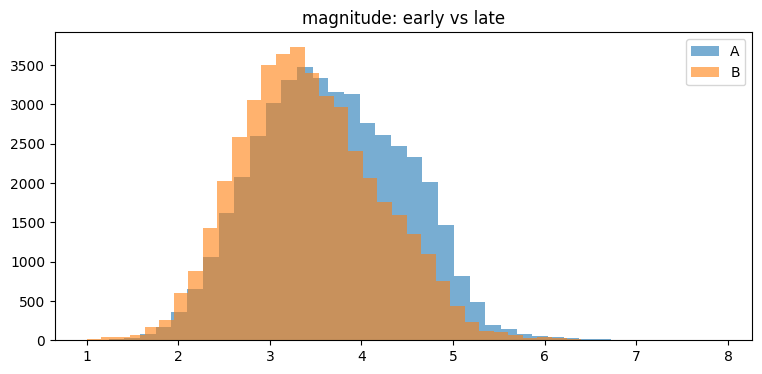

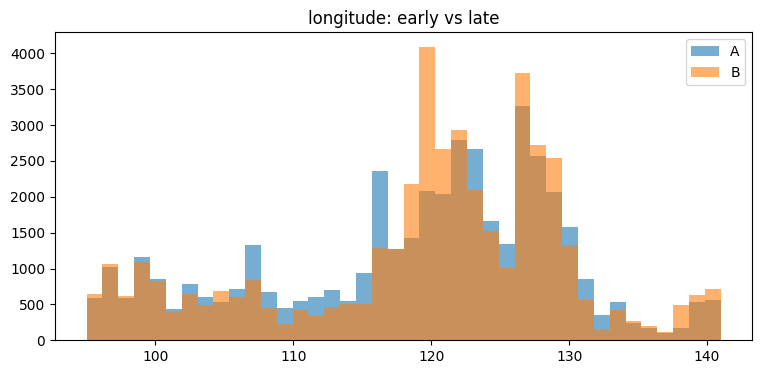

In [25]:
# Visualize drift for the top 2 drifting numeric features
top2 = drift_df["feature"].head(2).tolist()
for c in top2:
    plot_hist_compare(earthquake, c, mask_early, mask_late, bins=40, title=f"{c}: early vs late")


### تفسیر متریک‌های دریفت در زمینه واقعی

متریک‌های دریفت «سیگنال» هستند، نه نتیجه قطعی.

وقتی PSI/JSD برای یک ویژگی بزرگ است، دلایل احتمالی:
- تغییر واقعی در دنیا (مثلاً پوشش جغرافیایی متفاوت، سنسورهای جدید)
- تغییر در پایپ‌لاین بالادستی (تبدیل واحد، تغییر قوانین پارس کردن)
- افت کیفیت داده (گمشدگی بیشتر، مقادیر جایگزین/placeholder)
- تغییر در نمونه‌برداری (مناطق متفاوت، کاربران متفاوت)

گام بعدی معمولاً برش بر اساس *گروه‌های کلیدی* (مثلاً مکان، سیستم منبع) و تکرار تحلیل دریفت برای مکان‌یابی دقیق‌تر مشکل است.


## ۶) مشکلات برچسب (با `diabetes.csv`)

مشکلات برچسب شامل موارد زیر است:
- **برچسب‌های متناقض** برای ردیف‌های ویژگیِ یکسان یا تقریباً یکسان
- **نویز سیستماتیک برچسب** (مثلاً یک کلینیک اشتباه برچسب می‌زند)
- **ابهام برچسب** (مرزهای تصمیم‌گیری مبهم)
- **نشت برچسب** یا ویژگی‌های بعد از وقوع نتیجه که دقت «بیش از حد خوب» تولید می‌کنند

سه رویکرد اجرا می‌کنیم:
1. تشخیص تناقض با تکیه بر تکراری‌ها
2. غربال‌گری با «اختلاف با اطمینان بالا» توسط یک مدل ساده
3. برش‌های طبقه‌بندی‌شده برای دیدن تمرکز خطا در زیرگروه‌ها


In [26]:
diabetes = read_csv(PATHS["diabetes"])
basic_overview(diabetes, "diabetes")

[diabetes] shape = (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


,dtype,missing,missing_%,n_unique
Pregnancies,int64,0,0.0,17
Glucose,int64,0,0.0,136
BloodPressure,int64,0,0.0,47
SkinThickness,int64,0,0.0,51
Insulin,int64,0,0.0,186
BMI,float64,0,0.0,248
DiabetesPedigreeFunction,float64,0,0.0,517
Age,int64,0,0.0,52
classification,object,0,0.0,2


In [27]:
# Basic cleanup: normalize label values
label_col = "classification"
if label_col not in diabetes.columns:
    raise ValueError("Expected label column 'classification' not found.")

diabetes[label_col] = diabetes[label_col].astype(str).str.strip()
display(diabetes[label_col].value_counts(dropna=False))

classification
Non-Diabetic    500
Diabetic        268
Name: count, dtype: int64

In [28]:
# 1) Conflicting duplicates:
feature_cols = [c for c in diabetes.columns if c != label_col]

grp = diabetes.groupby(feature_cols)[label_col].nunique().reset_index(name="n_unique_labels")
conflicting = grp[grp["n_unique_labels"] > 1]

print("Number of distinct feature vectors with conflicting labels:", len(conflicting))
display(conflicting.head(10))

Number of distinct feature vectors with conflicting labels: 0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,n_unique_labels


In [29]:
# Pull example rows for conflicting feature vectors (if any)
if len(conflicting) > 0:
    ex = conflicting.iloc[0][feature_cols].to_dict()
    mask = np.ones(len(diabetes), dtype=bool)
    for c, v in ex.items():
        mask &= (diabetes[c] == v)
    display(diabetes.loc[mask, feature_cols + [label_col]].head(20))
else:
    print("No exact conflicting duplicates found. We'll use model-based triage next.")

No exact conflicting duplicates found. We'll use model-based triage next.


### غربال‌گری مبتنی بر مدل: اختلاف با اطمینان بالا

اگر یک مدل ساده و منظم‌شده با اطمینان بالا با برچسب یک ردیف مخالف باشد، آن ردیف *ارزش بررسی* دارد. این کار ثابت نمی‌کند برچسب غلط است؛ فقط نامزدهای بازبینی دستی را معرفی می‌کند.

در ادامه:
- یک رگرسیون لجستیک با وان-هات برای ستون‌های دسته‌ای (در صورت وجود) آموزش می‌دهیم
- احتمال‌های پیش‌بینی را محاسبه می‌کنیم
- نمونه‌هایی را که مدل خیلی مطمئن است اما با برچسب اختلاف دارد، علامت‌گذاری می‌کنیم

این یک روش رایج برای QA برچسب در عمل است.


In [30]:
# Prepare X/y
X = diabetes.drop(columns=[label_col]).copy()
y = diabetes[label_col].copy()

# Encode target to {0,1} in a stable way
classes = sorted(y.unique().tolist())
if len(classes) != 2:
    raise ValueError(f"Expected binary classification labels, got: {classes}")

pos_label = classes[1]
y_bin = (y == pos_label).astype(int)

# Identify categorical vs numeric columns
cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("string")]
num_cols = [c for c in X.columns if c not in cat_cols]

# Convert numeric columns robustly
for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors="coerce")

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

clf = LogisticRegression(max_iter=2000, solver="lbfgs")

pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.25, random_state=RANDOM_STATE, stratify=y_bin)
pipe.fit(X_train, y_train)

proba_test = pipe.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba_test)
print("Test ROC-AUC:", round(auc, 4))
print(classification_report(y_test, (proba_test >= 0.5).astype(int)))

Test ROC-AUC: 0.8247
              precision    recall  f1-score   support

           0       0.74      0.58      0.65        67
           1       0.80      0.89      0.84       125

    accuracy                           0.78       192
   macro avg       0.77      0.74      0.75       192
weighted avg       0.78      0.78      0.77       192



In [31]:
# High-confidence disagreements on the test set
test_idx = X_test.index
pred = (proba_test >= 0.5).astype(int)
wrong = pred != y_test.values

conf = np.maximum(proba_test, 1 - proba_test)
high_conf = conf >= 0.90

suspect_idx = test_idx[wrong & high_conf]
print("High-confidence disagreements:", len(suspect_idx))

suspects = diabetes.loc[suspect_idx, :].copy()
suspects["model_proba_pos"] = proba_test[wrong & high_conf]
suspects["true_label"] = diabetes.loc[suspect_idx, label_col].values
suspects = suspects.sort_values("model_proba_pos", ascending=False)

display(suspects.head(15))

High-confidence disagreements: 0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification,model_proba_pos,true_label


### برش خطا: اختلاف‌ها در کجا متمرکز می‌شوند؟

اگر اختلاف‌های با اطمینان بالا در یک زیرگروه متمرکز شوند، ممکن است نشان‌دهنده:
- مشکل در جمع‌آوری داده برای آن زیرگروه
- مشکل در پیش‌پردازش/اندازه‌گیری
- تغییر واقعی در زیرگروه باشد

چند برش ساده روی ویژگی‌های عددی انجام می‌دهیم و نرخ اختلاف را مقایسه می‌کنیم.


In [32]:
# Build a dataframe for analysis on the test set
analysis = diabetes.loc[test_idx, :].copy()
analysis["y_true"] = y_test.values
analysis["p_pos"] = proba_test
analysis["y_pred"] = pred
analysis["wrong"] = wrong
analysis["high_conf"] = high_conf
analysis["hc_wrong"] = analysis["wrong"] & analysis["high_conf"]

slice_cols = [c for c in ["Glucose", "BMI", "Age", "BloodPressure"] if c in analysis.columns]
slice_cols

['Glucose', 'BMI', 'Age', 'BloodPressure']

In [33]:
def bin_and_rate(df: pd.DataFrame, col: str, bins: int = 4) -> pd.DataFrame:
    x = pd.to_numeric(df[col], errors="coerce")
    b = pd.qcut(x, q=bins, duplicates="drop")
    out = df.groupby(b)["hc_wrong"].mean().reset_index(name="hc_wrong_rate")
    out["n"] = df.groupby(b)["hc_wrong"].size().values
    return out.sort_values("hc_wrong_rate", ascending=False)

for c in slice_cols:
    print("="*80)
    print("Slicing by:", c)
    display(bin_and_rate(analysis, c, bins=4))

Slicing by: Glucose


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27944\2491517543.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = df.groupby(b)["hc_wrong"].mean().reset_index(name="hc_wrong_rate")
C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27944\2491517543.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = df.groupby(b)["hc_wrong"].size().values


,Glucose,hc_wrong_rate,n
0,"(43.999, 98.0]",0.0,49
1,"(98.0, 111.5]",0.0,47
2,"(111.5, 135.75]",0.0,48
3,"(135.75, 196.0]",0.0,48


Slicing by: BMI


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27944\2491517543.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = df.groupby(b)["hc_wrong"].mean().reset_index(name="hc_wrong_rate")
C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27944\2491517543.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = df.groupby(b)["hc_wrong"].size().values


,BMI,hc_wrong_rate,n
0,"(-0.001, 27.0]",0.0,49
1,"(27.0, 31.6]",0.0,48
2,"(31.6, 36.8]",0.0,48
3,"(36.8, 57.3]",0.0,47


Slicing by: Age


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27944\2491517543.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = df.groupby(b)["hc_wrong"].mean().reset_index(name="hc_wrong_rate")
C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27944\2491517543.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = df.groupby(b)["hc_wrong"].size().values


,Age,hc_wrong_rate,n
0,"(20.999, 25.0]",0.0,56
1,"(25.0, 31.0]",0.0,43
2,"(31.0, 41.0]",0.0,49
3,"(41.0, 72.0]",0.0,44


Slicing by: BloodPressure


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27944\2491517543.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out = df.groupby(b)["hc_wrong"].mean().reset_index(name="hc_wrong_rate")
C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_27944\2491517543.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out["n"] = df.groupby(b)["hc_wrong"].size().values


,BloodPressure,hc_wrong_rate,n
0,"(-0.001, 62.0]",0.0,50
1,"(62.0, 70.0]",0.0,47
2,"(70.0, 80.0]",0.0,59
3,"(80.0, 110.0]",0.0,36


### پیوند دریفت و مشکلات برچسب

در محیط واقعی، مشکلات برچسب و دریفت با هم تعامل دارند:

- اگر فرایند برچسب‌گذاری در طول زمان تغییر کند، می‌توان **دریفت برچسب** یا **دریفت نویز برچسب** دید
- اگر توزیع داده تغییر کند، الگوی «اختلاف‌ها» نیز تغییر می‌کند

بنابراین برنامه پایش باید شامل موارد زیر باشد:
- بررسی دریفت ویژگی‌ها روی $X$
- بررسی توزیع برچسب روی $Y$ (وقتی برچسب‌ها می‌رسند)
- بررسی توزیع پیش‌بینی‌ها روی $\hat{Y}$ برای تشخیص شکست‌های بی‌سروصدا


## ۸) الگوهای پیشرفته کیفیت و ابتکارهای عملی

این بخش ابزارک را با الگوهایی گسترش می‌دهد که در پروژه‌های واقعیِ داده جدولی بسیار رایج‌اند.

### ۸.۱ ریسک نشت ناشی از تکراری‌ها در تقسیم داده

یک خطای رایج این است که تقسیم را تصادفی انجام دهید، در حالی که دیتاست دارای موجودیت‌های تکراری است (یک مشتری، یک بیمار، یک دستگاه). اگر تکراری‌ها هم در آموزش و هم در آزمون باشند، عملکرد را بیش‌برآورد می‌کنید.

اگر شناسه موجودیت $E$ داشته باشید (مثلاً شناسه مشتری)، تقسیم درست معمولاً **تقسیم گروهی** است: هر موجودیت فقط در یکی از بخش‌ها دیده شود.

### ۸.۲ مقادیر جایگزین (placeholder) در برابر مقادیر گم‌شده

برخی پایپ‌لاین‌ها مقدار گمشده را با placeholder نشان می‌دهند:
- عددی: `-1`، `999`، `0` (وقتی 0 معنی‌دار نیست)
- دسته‌ای: `"Unknown"`، `"N/A"`، `"None"`، رشته خالی

EDA خوب باید این الگوها را شناسایی کند و به شکل سازگار مدیریت کند.

### ۸.۳ «قله»‌های توزیع و ترجیح رقم

قله‌های شدید روی اعداد رُند (مثل 10، 20، 30) می‌تواند نشان‌دهنده آرتیفکت اندازه‌گیری (ترجیح رقم) باشد و گاهی با نویز برچسب هم‌بسته می‌شود.

### ۸.۴ تکراری‌های متناقض برای هدف رگرسیون

در رگرسیون، تکراری‌ها با هدف متفاوت معمولاً نشان‌دهنده نویز اندازه‌گیری، مشکل ادغام داده، یا دریفت در تعریف هدف است. واریانس هدف داخل گروه‌های تکراری را بررسی کنید.

### ۸.۵ امتیازدهی کیفیت داده (برای اولویت‌بندی)

می‌توانید یک امتیاز ریسک ساده به هر ردیف بدهید و ابتدا ردیف‌های پرریسک را بازبینی کنید. مثلاً:

$$
\mathrm{risk}(i) = w_1 \cdot \mathbf{1}[\text{missing\_critical}] + w_2 \cdot \mathbf{1}[\text{invalid\_format}] + w_3 \cdot \mathbf{1}[\text{duplicate\_key}] + w_4 \cdot \mathbf{1}[\text{drift\_bucket}]
$$

هدف، اولویت‌بندی است نه «کمال ریاضی».


In [34]:
# Example: placeholder detection utility and a simple row-risk score for the complaints dataset

PLACEHOLDERS = {"", "na", "n/a", "none", "null", "unknown", "<<na>>"}

def placeholder_rate(series: pd.Series) -> float:
    s = series.astype("string").str.strip().str.lower()
    return float(s.isin(PLACEHOLDERS).mean())

# Compute placeholder rates for a few text columns in complaints
text_cols = [c for c in ["Sub Product", "Sub Issue", "Consumer Complaint Narrative", "Company Public Response"] if c in complaints.columns]
rates = []
for c in text_cols:
    rates.append({"column": c, "placeholder_rate": placeholder_rate(complaints[c]), "missing_rate": float(complaints[c].isna().mean())})
pd.DataFrame(rates).sort_values("placeholder_rate", ascending=False)

,column,placeholder_rate,missing_rate
0,Sub Product,0.0,0.283424
1,Sub Issue,0.0,0.531932
2,Consumer Complaint Narrative,0.0,0.960091
3,Company Public Response,0.0,0.962595


In [35]:
# Row-level risk score example on complaints
risk = pd.Series(0.0, index=complaints.index)

# Rule 1: invalid ZIP (when present)
if "Zip Code" in complaints.columns:
    zip_s = complaints["Zip Code"].astype("string")
    invalid_zip = regex_invalid_mask(zip_s, r"^\d{5}$", allow_na=True) & zip_s.notna()
    risk += invalid_zip.astype(float) * 2.0

# Rule 2: invalid state code (when present)
if "State Name" in complaints.columns:
    st = complaints["State Name"].astype("string")
    invalid_state = regex_invalid_mask(st, r"^[A-Z]{2}$", allow_na=True) & st.notna()
    risk += invalid_state.astype(float) * 1.0

# Rule 3: date order violation (sent < received)
if "Date Received" in complaints.columns and "Date Sent to Company" in complaints.columns:
    dr = pd.to_datetime(complaints["Date Received"], errors="coerce")
    ds = pd.to_datetime(complaints["Date Sent to Company"], errors="coerce")
    order_violation = ds.notna() & dr.notna() & (ds < dr)
    risk += order_violation.astype(float) * 3.0

# Rule 4: exact duplicate rows
risk += complaints.duplicated(keep=False).astype(float) * 1.5

risk_summary = pd.DataFrame({"risk_score": risk})
risk_summary["risk_bucket"] = pd.cut(risk_summary["risk_score"], bins=[-0.01, 0.0, 1.0, 3.0, 10.0], labels=["0", "(0,1]", "(1,3]", "(3,10]"])
display(risk_summary["risk_bucket"].value_counts(dropna=False))

# Inspect the highest-risk rows
top_risk_idx = risk_summary.sort_values("risk_score", ascending=False).head(10).index
display(complaints.loc[top_risk_idx, ["Date Received", "Date Sent to Company", "State Name", "Zip Code", "Company", "Product Name", "Issue"]].copy())

risk_bucket
0         55928
(1,3]      9463
(3,10]      108
(0,1]         0
Name: count, dtype: int64

,Date Received,Date Sent to Company,State Name,Zip Code,Company,Product Name,Issue
16119,2014-01-18,2014-01-17,NJ,7054,Wells Fargo & Company,Mortgage,"Loan modification,collection,foreclosure"
11857,2013-12-12,2013-12-11,RI,2910,Synchrony Financial,Credit card,Billing disputes
17535,2014-01-25,2014-01-24,MA,1083,Citibank,Bank account or service,"Making/receiving payments, sending money"
14775,2014-01-08,2014-01-07,NJ,8648,Ocwen,Mortgage,"Loan servicing, payments, escrow account"
17451,2014-02-20,2014-02-19,CT,6067,Citibank,Credit card,APR or interest rate
14504,2014-01-13,2014-01-12,VT,5753,"TransUnion Intermediate Holdings, Inc.",Credit reporting,Incorrect information on credit report
574,2013-08-13,2013-08-12,NJ,7305,Experian,Credit reporting,Credit reporting company's investigation
91,2013-07-31,2013-07-30,NJ,7018,Citibank,Credit card,Payoff process
15191,2014-02-01,2014-01-31,CT,6416,Ditech Financial LLC,Mortgage,"Loan modification,collection,foreclosure"
8532,2013-10-21,2013-10-20,CT,6511,Equifax,Credit reporting,Incorrect information on credit report


## ۹) راهنمای عملی پایش کیفیت و دریفت

برنامه پایش باید بر اساس *مودهای شکست* و *اثر تصمیم* طراحی شود. یک مجموعه ساده اما مؤثر از پایش‌ها:

### ۹.۱ پایش اسکیمـا (خطاهای سخت)
- بررسی وجود ستون‌ها و نوع داده
- مجموعه دسته‌های مجاز برای ستون‌های حیاتی
- بررسی رِجِکس برای شناسه‌ها، تاریخ‌ها، کدپستی

### ۹.۲ پایش آماری (خطاهای نرم)
- نرخ گمشدگی به ازای ستون
- متریک‌های دریفت (PSI/JSD) برای ویژگی‌های کلیدی
- سهم دسته‌های پرتکرار در ستون‌های دسته‌ای (برای مشاهده جهش‌های ناگهانی)

### ۹.۳ پایش‌های مدل‌محور
- دریفت توزیع پیش‌بینی‌ها: $p(\hat{Y})$
- دریفت اطمینان: توزیع بیشینه احتمال
- پایش عملکرد زیرگروه‌ها (وقتی برچسب‌ها برسند)

### ۹.۴ طراحی هشدار
- آستانه‌ها را به عنوان *تریاژ* ببینید، نه فرمان بازگشت خودکار.
- سیگنال‌ها را ترکیب کنید: مثلاً هشدار وقتی PSI بالاست **و** گمشدگی زیاد شده.
- «بچ‌های بد» را برای تحلیل جرم‌شناسانه ذخیره کنید.

### ۹.۵ متریک‌های حداقلی داشبورد
می‌توانید با ۱۰ تا ۲۰ ویژگی حیاتی و پایدار شروع کنید و سپس گسترش دهید.

در این نوت‌بوک داشبورد کامل نمی‌سازیم، اما همین کدی که نوشتید (PSI/JSD و قوانین) دقیقاً خوراک آن است.


## ۷) ساخت گزارش EDA کیفیت داده (قالب پیشنهادی)

در ادامه یک ساختار مشخص برای پروژه‌ها ارائه می‌شود. تمرکز اصلی روی **تصمیم‌ها** و **اقدام‌ها** است.

### الف) نمای کلی دیتاست
- تعداد ردیف‌ها، تعداد ستون‌ها و نوع داده‌ها
- خلاصه گمشدگی (به ازای ستون و به ازای ردیف)
- دسته‌های پرتکرار برای ستون‌های پرکاردینالیتی
- آمار توصیفی برای ستون‌های عددی

### ب) یافته‌ها بر اساس ابعاد کیفیت
1. **کامل‌بودن**: ستون‌های با گمشدگی بالا؛ ارتباط گمشدگی با هدف یا ویژگی‌های مهم
2. **یکتایی**: تکراری‌های دقیق؛ برخورد کلیدها؛ تکرار در شناسه‌های موجودیت
3. **اعتبار**: مقادیر خارج از بازه؛ فرمت نامعتبر؛ مقادیر غیرممکن
4. **سازگاری**: دسته‌های ناسازگار؛ نقض قوانین بین‌ستونی؛ ناهنجاری واحد/فرمت
5. **دریفت**: متریک‌های دریفت خط‌مبنا در برابر دوره فعلی؛ کدام ویژگی‌ها جابه‌جا شده‌اند؛ کدام برش‌ها بیشترین تغییر را نشان می‌دهند
6. **برچسب‌ها**: تکراری‌های متناقض؛ نامزدهای اختلاف با اطمینان بالا؛ تمرکز در زیرگروه‌ها

### ج) ارزیابی ریسک
برای هر مشکل پاسخ دهید:
- اثر آن بر آموزش، ارزیابی یا استقرار چیست؟
- آیا باعث نشت می‌شود؟ آیا متریک‌ها را بایاس می‌کند؟
- مشکل محلی است یا سراسری؟
- ریشه محتمل چیست (جمع‌آوری vs ورود داده vs تبدیل)?

### د) برنامه اصلاح
برای هر مشکل مشخص کنید:
- روش اصلاح: مقداردهی/تصحیح/حذف تکراری/بازبرچسب‌گذاری/فیلتر/افزودن قید
- مالک و محل: سیستم بالادستی، گام ETL، دستورالعمل برچسب‌گذاری
- اعتبارسنجی: کدام بررسی از تکرار جلوگیری می‌کند

### هـ) برنامه پایش
- متریک‌های دریفت و پنجره‌ها (روزانه/هفتگی/ماهانه)
- آستانه‌های کیفیت و هشدارها
- راهبرد نمونه‌برداری برای QA برچسب (بازبینی انسانی)
- برنامه بک‌تست و پایش پس از استقرار

### تمرین‌های کوتاه (پیشنهادی)
1. یک قانون جدید برای `ConsumerComplaints` اضافه کنید (مثلاً یکتایی `Complaint ID`).
2. دریفت ستون‌های دسته‌ای (مثلاً `Product Name`) را بین دوره‌های مختلف بر اساس `Date Received` محاسبه کنید.
3. برای `diabetes.csv` بررسی کنید اختلاف‌های با اطمینان بالا بر اساس `Pregnancies` یا `Insulin` متمرکز می‌شوند یا نه.
